## Using a genetic algorithm to search for relevent features in the compiled target dataframe

The sklearn.svm.NuSVR algorithm is a good performer with this data, and immediately returns a model with 94.6% R2 when fed all the features. The goal here is to find a minimal set of features that performs nearly as well, since not all algorithms are as tolerent of high dimensions. 

I find this prefereable to Principle Component Analysis because PCA doesn't evaluate outlier target variables; it only shows vectors of movement within correlated inputs. This is useful but in a situation where mis-predicted outliers are dangerous, it may be better to find a subset of features that performs as well and just use those. 

Another reason to prefer this over PCA, if it works, is that it is much easier to continually collect data on a smaller number of features that matter than on a larger number of features that need to be fed into PCA.

## Uses https://pypi.org/project/sklearn-genetic/ 
Citation: Manuel Calzolari. (2021, April 3). manuel-calzolari/sklearn-genetic: sklearn-genetic 0.4.0 (Version 0.4.0). Zenodo. http://doi.org/10.5281/zenodo.4661178

Source code at https://github.com/manuel-calzolari/sklearn-genetic/blob/master/genetic_selection/gscv.py

## Additional setup reqired:
"conda install -c conda-forge sklearn-genetic"

# Runs in about 5 minutes on my reasonably new laptop


In [1]:
# Import required libraries 

import pandas as pd 
import numpy as np 

### Load the predictors and target data to a pandas dataframe


In [2]:
target_df = pd.read_csv("dataframes/target_df.csv.gz", compression="infer", parse_dates = ["opday"])

### View the source data

Always view the source data.  Pandas makes this trivial.

In [3]:
target_df.head()

,opday,sum_spp_load,is_Friday,is_Monday,is_Saturday,is_Sunday,is_Thursday,is_Tuesday,is_Wednesday,holiday_Christmas Day,...,HDD_TX_DALLAS_FT_WORTH_AP,HDD_TX_DALLAS_LOVE_FLD,HDD_TX_FT_WORTH_ALLIANCE_AP,HDD_TX_LUBBOCK,HDD_TX_MIDLAND_ODESSA,HDD_TX_SAN_ANGELO,HDD_TX_WACO_RGNL_AP,HDD_TX_WICHITA_FALLS_MUNI_AP,HDD_WY_CHEYENNE,HDD_WY_TORRINGTON_MUNI_AP
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2,2015-10-03,566229.834662,0,0,1,0,0,0,0,0,...,0.0,0.0,1.05,5.28,0.00,0.0,0.0,3.30,18.24,16.98
3,2015-10-04,552166.723416,0,0,0,1,0,0,0,0,...,0.0,0.0,0.00,8.34,0.00,0.0,0.0,1.14,18.96,15.00
4,2015-10-05,596751.461994,0,1,0,0,0,0,0,0,...,0.0,0.0,0.00,7.44,1.14,0.0,0.0,1.14,12.30,7.08
5,2015-10-06,622735.355003,0,0,0,0,0,1,0,0,...,0.0,0.0,0.00,3.48,0.00,0.0,0.0,0.60,12.12,8.97
6,2015-10-07,645464.796588,0,0,0,0,0,0,1,0,...,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,7.44,0.51


In [4]:
target_df.describe()

,sum_spp_load,is_Friday,is_Monday,is_Saturday,is_Sunday,is_Thursday,is_Tuesday,is_Wednesday,holiday_Christmas Day,holiday_Christmas Eve,...,HDD_TX_DALLAS_FT_WORTH_AP,HDD_TX_DALLAS_LOVE_FLD,HDD_TX_FT_WORTH_ALLIANCE_AP,HDD_TX_LUBBOCK,HDD_TX_MIDLAND_ODESSA,HDD_TX_SAN_ANGELO,HDD_TX_WACO_RGNL_AP,HDD_TX_WICHITA_FALLS_MUNI_AP,HDD_WY_CHEYENNE,HDD_WY_TORRINGTON_MUNI_AP
count,1.535000e+03,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,...,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000
mean,7.178639e+05,0.142671,0.143974,0.142671,0.143322,0.141368,0.142671,0.143322,0.003909,0.003257,...,5.443349,5.159023,6.173375,8.910704,6.428717,5.824339,5.486463,7.879974,19.121863,18.240430
std,1.007130e+05,0.349851,0.351178,0.349851,0.350516,0.348514,0.349851,0.350516,0.062418,0.056999,...,8.633520,8.407970,9.136330,11.073380,9.305757,8.850519,8.568441,10.596462,15.683710,16.434591
min,5.400074e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.367939e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.480000,0.000000
50%,6.941424e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.760000,0.000000,0.000000,0.000000,0.960000,18.600000,16.890000
75%,7.862803e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.060000,8.340000,10.995000,16.620000,11.760000,10.500000,9.420000,14.190000,30.660000,29.850000
max,1.016596e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,42.000000,41.820000,44.970000,52.980000,46.860000,45.420000,44.520000,48.660000,69.540000,76.380000


In [5]:
target_df.columns


Index(['opday', 'sum_spp_load', 'is_Friday', 'is_Monday', 'is_Saturday',
       'is_Sunday', 'is_Thursday', 'is_Tuesday', 'is_Wednesday',
       'holiday_Christmas Day',
       ...
       'HDD_TX_DALLAS_FT_WORTH_AP', 'HDD_TX_DALLAS_LOVE_FLD',
       'HDD_TX_FT_WORTH_ALLIANCE_AP', 'HDD_TX_LUBBOCK',
       'HDD_TX_MIDLAND_ODESSA', 'HDD_TX_SAN_ANGELO', 'HDD_TX_WACO_RGNL_AP',
       'HDD_TX_WICHITA_FALLS_MUNI_AP', 'HDD_WY_CHEYENNE',
       'HDD_WY_TORRINGTON_MUNI_AP'],
      dtype='object', length=483)

## Selection of the predictor measures

and convert the predictors and target to a numpy matrix and vector respectively



In [6]:
# One of the goals of dimension reduction is to reduce the amount of work it takes 
# to gather the data. 
# I am very interested in which airports' average temperatures are most effective 
# at predicting demand in the SPP; therefore I only use TAVG and left out TMIN, TMAX, HDD, and CDD. 

predictors_df = target_df[[
    'is_Friday', 'is_Monday', 'is_Saturday', 'is_Sunday', 'is_Thursday',
    'is_Tuesday', 'is_Wednesday', 'holiday_Christmas Day',
    'holiday_Christmas Eve', 'holiday_Day After Thanksgiving',
    'holiday_Independence Day', 'holiday_Labor Day', 'holiday_Memorial Day',
    "holiday_New Year's Day", 'holiday_Thanksgiving', 
  #  'is_holiday',
    'TAVG_AR_FAYETTEVILLE_DRAKE_FLD', 'TAVG_AR_FT_SMITH_RGNL_AP',
    'TAVG_AR_HARRISON_BOONE_CO_AP', 'TAVG_AR_HOT_SPRINGS_ASOS',
    'TAVG_AR_LITTLE_ROCK', 'TAVG_AR_LITTLE_ROCK_AP_ADAMS_FLD',
    'TAVG_AR_MOUNTAIN_HOME_BAXTER_AP', 'TAVG_AR_MOUNT_IDA_ASOS',
    'TAVG_AR_TEXARKANA_WEBB_FLD', 'TAVG_CO_ALAMOSA_SAN_LUIS_AP',
    'TAVG_CO_BURLINGTON_CARSON_AP', 'TAVG_CO_COLORADO_SPRINGS_MUNI_AP',
    'TAVG_CO_DENVER_CENTENNIAL_AP', 'TAVG_CO_DENVER_INTL_AP',
    'TAVG_CO_PUEBLO_MEM_AP', 'TAVG_IA_AMES_MUNI_AP',
    'TAVG_IA_DES_MOINES_INTL_AP', 'TAVG_IA_ESTHERVILLE_MUNI_AP',
    'TAVG_IA_MARSHALLTOWN_MUNI_AP', 'TAVG_IA_MASON_CITY_MUNI_AP',
    'TAVG_IA_SIOUX_CITY_GATEWAY_AP', 'TAVG_IA_WATERLOO_MUNI_AP',
    'TAVG_KS_ANTHONY', 'TAVG_KS_CONCORDIA_MUNI_AP', 'TAVG_KS_DODGE_CITY',
    'TAVG_KS_GOODLAND', 'TAVG_KS_HILL_CITY_MUNI_AP', 'TAVG_KS_TOPEKA_MUNI_AP',
    'TAVG_KS_WICHITA', 'TAVG_LA_SHREVEPORT', 'TAVG_MN_DULUTH',
    'TAVG_MN_INTL_FALLS_INTL_AP', 'TAVG_MN_MINNEAPOLIS/ST_PAUL_AP',
    'TAVG_MN_MPLS_CRYSTAL_AP', 'TAVG_MN_MPLS_FLYING_CLOUD_AP',
    'TAVG_MN_ROCHESTER_INTL_AP', 'TAVG_MN_ST_CLOUD_RGNL_AP',
    'TAVG_MN_ST_PAUL_DOWNTOWN_AP', 'TAVG_MO_KANSAS_CITY_INTL_AP',
    'TAVG_MO_SPRINGFIELD', 'TAVG_MT_BAKER_MUNI_AP',
    'TAVG_MT_MILES_CITY_F_WILEY_FLD', 'TAVG_ND_BISMARCK',
    'TAVG_ND_FARGO_HECTOR_INTL_AP', 'TAVG_ND_GARRISON',
    'TAVG_ND_GRAND_FORKS_INTL_AP', 'TAVG_ND_HETTINGER_MUNI_AP',
    'TAVG_ND_JAMESTOWN_MUNI_AP', 'TAVG_ND_MINOT_INTL_AP',
    'TAVG_ND_THEODORE_ROOSEVELT_AP', 'TAVG_NE_BROKEN_BOW_MUNI_AP',
    'TAVG_NE_CHADRON_MUNI_AP', 'TAVG_NE_FALLS_CITY_BRENNER_FLD',
    'TAVG_NE_GRAND_ISLAND_AP', 'TAVG_NE_HASTINGS_MUNI_AP',
    'TAVG_NE_HAYES_CENTER_1NW', 'TAVG_NE_IMPERIAL_MUNI_AP',
    'TAVG_NE_LINCOLN_MUNI_AP', 'TAVG_NE_NORFOLK_KARL_STEFAN_AP',
    'TAVG_NE_NORTH_PLATTE_RGNL_AP', 'TAVG_NE_OMAHA_EPPLEY_AIRFIELD',
    'TAVG_NE_SCOTTSBLUFF_HEILIG_AP', 'TAVG_NE_VALENTINE_MILLER_FLD',
    'TAVG_NM_CLAYTON_MUNI_AIR_PK', 'TAVG_NM_LAS_VEGAS_MUNI_AP',
    'TAVG_NM_ROSWELL_IND_AIR_PK', 'TAVG_OK_BARTLESVILLE_F_P_FLD',
    'TAVG_OK_LAWTON_MUNI_AP', 'TAVG_OK_OKLAHOMA_CITY_WILL_ROGERS_AP',
    'TAVG_OK_TULSA_INTL_AP', 'TAVG_SD_ABERDEEN', 'TAVG_SD_HURON_RGNL_AP',
    'TAVG_SD_MITCHELL_MUNI_AP', 'TAVG_SD_MOBRIDGE_MUNI_AP',
    'TAVG_SD_RAPID_CITY_RGNL_AP', 'TAVG_SD_SIOUX_FALLS',
    'TAVG_SD_SISSETON_MUNI_AP', 'TAVG_SD_WATERTOWN_RGNL_AP',
    'TAVG_SD_YANKTON_2_E', 'TAVG_TX_ABILENE_RGNL_AP', 'TAVG_TX_AMARILLO',
    'TAVG_TX_CHILDRESS_MUNI_AP', 'TAVG_TX_DALHART_MUNI_AP',
    'TAVG_TX_DALLAS_FT_WORTH_AP', 'TAVG_TX_DALLAS_LOVE_FLD',
    'TAVG_TX_FT_WORTH_ALLIANCE_AP', 'TAVG_TX_LUBBOCK', 'TAVG_TX_MIDLAND_ODESSA',
    'TAVG_TX_SAN_ANGELO', 'TAVG_TX_WACO_RGNL_AP',
    'TAVG_TX_WICHITA_FALLS_MUNI_AP', 'TAVG_WY_CHEYENNE',
    'TAVG_WY_TORRINGTON_MUNI_AP',
    
# though I suppose we could try with TMIN and TMAX also and see if anything shakes out
    
    'TMIN_AR_FAYETTEVILLE_DRAKE_FLD', 'TMIN_AR_FT_SMITH_RGNL_AP',
    'TMIN_AR_HARRISON_BOONE_CO_AP', 'TMIN_AR_HOT_SPRINGS_ASOS',
    'TMIN_AR_LITTLE_ROCK', 'TMIN_AR_LITTLE_ROCK_AP_ADAMS_FLD',
    'TMIN_AR_MOUNTAIN_HOME_BAXTER_AP', 'TMIN_AR_MOUNT_IDA_ASOS',
    'TMIN_AR_TEXARKANA_WEBB_FLD', 'TMIN_CO_ALAMOSA_SAN_LUIS_AP',
    'TMIN_CO_BURLINGTON_CARSON_AP', 'TMIN_CO_COLORADO_SPRINGS_MUNI_AP',
    'TMIN_CO_DENVER_CENTENNIAL_AP', 'TMIN_CO_DENVER_INTL_AP',
    'TMIN_CO_PUEBLO_MEM_AP', 'TMIN_IA_AMES_MUNI_AP',
    'TMIN_IA_DES_MOINES_INTL_AP', 'TMIN_IA_ESTHERVILLE_MUNI_AP',
    'TMIN_IA_MARSHALLTOWN_MUNI_AP', 'TMIN_IA_MASON_CITY_MUNI_AP',
    'TMIN_IA_SIOUX_CITY_GATEWAY_AP', 'TMIN_IA_WATERLOO_MUNI_AP',
    'TMIN_KS_ANTHONY', 'TMIN_KS_CONCORDIA_MUNI_AP', 'TMIN_KS_DODGE_CITY',
    'TMIN_KS_GOODLAND', 'TMIN_KS_HILL_CITY_MUNI_AP', 'TMIN_KS_TOPEKA_MUNI_AP',
    'TMIN_KS_WICHITA', 'TMIN_LA_SHREVEPORT', 'TMIN_MN_DULUTH',
    'TMIN_MN_INTL_FALLS_INTL_AP', 'TMIN_MN_MINNEAPOLIS/ST_PAUL_AP',
    'TMIN_MN_MPLS_CRYSTAL_AP', 'TMIN_MN_MPLS_FLYING_CLOUD_AP',
    'TMIN_MN_ROCHESTER_INTL_AP', 'TMIN_MN_ST_CLOUD_RGNL_AP',
    'TMIN_MN_ST_PAUL_DOWNTOWN_AP', 'TMIN_MO_KANSAS_CITY_INTL_AP',
    'TMIN_MO_SPRINGFIELD', 'TMIN_MT_BAKER_MUNI_AP',
    'TMIN_MT_MILES_CITY_F_WILEY_FLD', 'TMIN_ND_BISMARCK',
    'TMIN_ND_FARGO_HECTOR_INTL_AP', 'TMIN_ND_GARRISON',
    'TMIN_ND_GRAND_FORKS_INTL_AP', 'TMIN_ND_HETTINGER_MUNI_AP',
    'TMIN_ND_JAMESTOWN_MUNI_AP', 'TMIN_ND_MINOT_INTL_AP',
    'TMIN_ND_THEODORE_ROOSEVELT_AP', 'TMIN_NE_BROKEN_BOW_MUNI_AP',
    'TMIN_NE_CHADRON_MUNI_AP', 'TMIN_NE_FALLS_CITY_BRENNER_FLD',
    'TMIN_NE_GRAND_ISLAND_AP', 'TMIN_NE_HASTINGS_MUNI_AP',
    'TMIN_NE_HAYES_CENTER_1NW', 'TMIN_NE_IMPERIAL_MUNI_AP',
    'TMIN_NE_LINCOLN_MUNI_AP', 'TMIN_NE_NORFOLK_KARL_STEFAN_AP',
    'TMIN_NE_NORTH_PLATTE_RGNL_AP', 'TMIN_NE_OMAHA_EPPLEY_AIRFIELD',
    'TMIN_NE_SCOTTSBLUFF_HEILIG_AP', 'TMIN_NE_VALENTINE_MILLER_FLD',
    'TMIN_NM_CLAYTON_MUNI_AIR_PK', 'TMIN_NM_LAS_VEGAS_MUNI_AP',
    'TMIN_NM_ROSWELL_IND_AIR_PK', 'TMIN_OK_BARTLESVILLE_F_P_FLD',
    'TMIN_OK_LAWTON_MUNI_AP', 'TMIN_OK_OKLAHOMA_CITY_WILL_ROGERS_AP',
    'TMIN_OK_TULSA_INTL_AP', 'TMIN_SD_ABERDEEN', 'TMIN_SD_HURON_RGNL_AP',
    'TMIN_SD_MITCHELL_MUNI_AP', 'TMIN_SD_MOBRIDGE_MUNI_AP',
    'TMIN_SD_RAPID_CITY_RGNL_AP', 'TMIN_SD_SIOUX_FALLS',
    'TMIN_SD_SISSETON_MUNI_AP', 'TMIN_SD_WATERTOWN_RGNL_AP',
    'TMIN_SD_YANKTON_2_E', 'TMIN_TX_ABILENE_RGNL_AP', 'TMIN_TX_AMARILLO',
    'TMIN_TX_CHILDRESS_MUNI_AP', 'TMIN_TX_DALHART_MUNI_AP',
    'TMIN_TX_DALLAS_FT_WORTH_AP', 'TMIN_TX_DALLAS_LOVE_FLD',
    'TMIN_TX_FT_WORTH_ALLIANCE_AP', 'TMIN_TX_LUBBOCK', 'TMIN_TX_MIDLAND_ODESSA',
    'TMIN_TX_SAN_ANGELO', 'TMIN_TX_WACO_RGNL_AP',
    'TMIN_TX_WICHITA_FALLS_MUNI_AP', 'TMIN_WY_CHEYENNE',
    'TMIN_WY_TORRINGTON_MUNI_AP',
    
    'TMAX_AR_FAYETTEVILLE_DRAKE_FLD', 'TMAX_AR_FT_SMITH_RGNL_AP',
    'TMAX_AR_HARRISON_BOONE_CO_AP', 'TMAX_AR_HOT_SPRINGS_ASOS',
    'TMAX_AR_LITTLE_ROCK', 'TMAX_AR_LITTLE_ROCK_AP_ADAMS_FLD',
    'TMAX_AR_MOUNTAIN_HOME_BAXTER_AP', 'TMAX_AR_MOUNT_IDA_ASOS',
    'TMAX_AR_TEXARKANA_WEBB_FLD', 'TMAX_CO_ALAMOSA_SAN_LUIS_AP',
    'TMAX_CO_BURLINGTON_CARSON_AP', 'TMAX_CO_COLORADO_SPRINGS_MUNI_AP',
    'TMAX_CO_DENVER_CENTENNIAL_AP', 'TMAX_CO_DENVER_INTL_AP',
    'TMAX_CO_PUEBLO_MEM_AP', 'TMAX_IA_AMES_MUNI_AP',
    'TMAX_IA_DES_MOINES_INTL_AP', 'TMAX_IA_ESTHERVILLE_MUNI_AP',
    'TMAX_IA_MARSHALLTOWN_MUNI_AP', 'TMAX_IA_MASON_CITY_MUNI_AP',
    'TMAX_IA_SIOUX_CITY_GATEWAY_AP', 'TMAX_IA_WATERLOO_MUNI_AP',
    'TMAX_KS_ANTHONY', 'TMAX_KS_CONCORDIA_MUNI_AP', 'TMAX_KS_DODGE_CITY',
    'TMAX_KS_GOODLAND', 'TMAX_KS_HILL_CITY_MUNI_AP', 'TMAX_KS_TOPEKA_MUNI_AP',
    'TMAX_KS_WICHITA', 'TMAX_LA_SHREVEPORT', 'TMAX_MN_DULUTH',
    'TMAX_MN_INTL_FALLS_INTL_AP', 'TMAX_MN_MINNEAPOLIS/ST_PAUL_AP',
    'TMAX_MN_MPLS_CRYSTAL_AP', 'TMAX_MN_MPLS_FLYING_CLOUD_AP',
    'TMAX_MN_ROCHESTER_INTL_AP', 'TMAX_MN_ST_CLOUD_RGNL_AP',
    'TMAX_MN_ST_PAUL_DOWNTOWN_AP', 'TMAX_MO_KANSAS_CITY_INTL_AP',
    'TMAX_MO_SPRINGFIELD', 'TMAX_MT_BAKER_MUNI_AP',
    'TMAX_MT_MILES_CITY_F_WILEY_FLD', 'TMAX_ND_BISMARCK',
    'TMAX_ND_FARGO_HECTOR_INTL_AP', 'TMAX_ND_GARRISON',
    'TMAX_ND_GRAND_FORKS_INTL_AP', 'TMAX_ND_HETTINGER_MUNI_AP',
    'TMAX_ND_JAMESTOWN_MUNI_AP', 'TMAX_ND_MINOT_INTL_AP',
    'TMAX_ND_THEODORE_ROOSEVELT_AP', 'TMAX_NE_BROKEN_BOW_MUNI_AP',
    'TMAX_NE_CHADRON_MUNI_AP', 'TMAX_NE_FALLS_CITY_BRENNER_FLD',
    'TMAX_NE_GRAND_ISLAND_AP', 'TMAX_NE_HASTINGS_MUNI_AP',
    'TMAX_NE_HAYES_CENTER_1NW', 'TMAX_NE_IMPERIAL_MUNI_AP',
    'TMAX_NE_LINCOLN_MUNI_AP', 'TMAX_NE_NORFOLK_KARL_STEFAN_AP',
    'TMAX_NE_NORTH_PLATTE_RGNL_AP', 'TMAX_NE_OMAHA_EPPLEY_AIRFIELD',
    'TMAX_NE_SCOTTSBLUFF_HEILIG_AP', 'TMAX_NE_VALENTINE_MILLER_FLD',
    'TMAX_NM_CLAYTON_MUNI_AIR_PK', 'TMAX_NM_LAS_VEGAS_MUNI_AP',
    'TMAX_NM_ROSWELL_IND_AIR_PK', 'TMAX_OK_BARTLESVILLE_F_P_FLD',
    'TMAX_OK_LAWTON_MUNI_AP', 'TMAX_OK_OKLAHOMA_CITY_WILL_ROGERS_AP',
    'TMAX_OK_TULSA_INTL_AP', 'TMAX_SD_ABERDEEN', 'TMAX_SD_HURON_RGNL_AP',
    'TMAX_SD_MITCHELL_MUNI_AP', 'TMAX_SD_MOBRIDGE_MUNI_AP',
    'TMAX_SD_RAPID_CITY_RGNL_AP', 'TMAX_SD_SIOUX_FALLS',
    'TMAX_SD_SISSETON_MUNI_AP', 'TMAX_SD_WATERTOWN_RGNL_AP',
    'TMAX_SD_YANKTON_2_E', 'TMAX_TX_ABILENE_RGNL_AP', 'TMAX_TX_AMARILLO',
    'TMAX_TX_CHILDRESS_MUNI_AP', 'TMAX_TX_DALHART_MUNI_AP',
    'TMAX_TX_DALLAS_FT_WORTH_AP', 'TMAX_TX_DALLAS_LOVE_FLD',
    'TMAX_TX_FT_WORTH_ALLIANCE_AP', 'TMAX_TX_LUBBOCK', 'TMAX_TX_MIDLAND_ODESSA',
    'TMAX_TX_SAN_ANGELO', 'TMAX_TX_WACO_RGNL_AP',
    'TMAX_TX_WICHITA_FALLS_MUNI_AP', 'TMAX_WY_CHEYENNE',
    'TMAX_WY_TORRINGTON_MUNI_AP',
]].copy()


# everything:
#predictors_df = target_df.drop(['opday', 'sum_spp_load'], axis=1).copy()


In [7]:
# try "months since 2015"; this should work as well as opday if it is only modeling load growth over time 
# predictors_df['opmonth'] = (target_df.opday.dt.year - 2015) * 12 + target_df.opday.dt.month 

In [8]:
predictor_names = predictors_df.columns.to_numpy()
predictors = predictors_df.to_numpy()

# only include status in the target array 
target = target_df['sum_spp_load'].to_numpy()

### Scale the predictors



In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((0, 1))
X = scaler.fit_transform(predictors)
y = scaler.fit_transform(target.reshape(-1, 1)).ravel()


### Split into training and testing sets

both the predictors and the targes, together, into a training set (75%) and a testing set (25%). Use constant random seed for repeatability but test with other random seeds to validate results.

## NOTE!  
Since the demand on adjacent days is similar, and I'm really interested in predicting new data as both "unseen" data and "future" data, I am NOT shuffling my training and test data, but instead training with the first majority of the data and testing with the following (future) days.

In [10]:
from sklearn.model_selection import train_test_split

# setting random_state will give the same split each time. 
# original code used random_state = 7 which allows very good predictions with this data; other values not so good.  
# I use 997 for more challenge. Using this split, all predictors work worse than a subset of predictors.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 997)

print (f"Input split into {len(y_train)} training observations and {len(y_test)} testing observations.")

Input split into 1151 training observations and 384 testing observations.


In [11]:
# Since this is time-series data and we are ultimately interested in a models ability to predict future results, 
# set the training data to be the first 80% of the values, and let the test day be the last 20% (future) values.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .237, shuffle=False)

print (f"Input split into {len(y_train)} training observations and {len(y_test)} testing observations.")

Input split into 1171 training observations and 364 testing observations.


In [12]:
from sklearn import metrics

# use all the continuous regression metrics from 
# https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

report=pd.DataFrame(columns=['Algorithm', 'Explained Variance', 'R2/COD', 'Max Error', 'Mean AE', 
                             'Mean Squared Error', 'MAPE',
                             'Median AE'])

def add_to_report(rep, algorithm, y_test, y_pred):
    explained_variance = metrics.explained_variance_score(y_test, y_pred)
    r2_score = metrics.r2_score(y_test, y_pred)
    max_error = metrics.max_error(y_test, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_test, y_pred)
    mean_squared_error = metrics.mean_squared_error(y_test, y_pred)
#    mean_squared_log_error = metrics.mean_squared_log_error(y_test, y_pred)
#    Mean Squared Logarithmic Error cannot be used when targets contain negative values.
    mean_absolute_percentage_error = metrics.mean_absolute_percentage_error(y_test, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_test, y_pred)
    rep.loc[len(rep.index)] = [algorithm, explained_variance, r2_score, max_error, mean_absolute_error,
                              mean_squared_error, mean_absolute_percentage_error,
                              median_absolute_error]
    return rep

In [13]:
# scatter plot true vs. predicted values 
import pylab as pl
%matplotlib inline
from pylab import *

def myplot (algorithm, x_axis, y_axis):
    pl.figure(figsize=(8, 6), dpi=120)
    pl.scatter(x_axis, x_axis,  c="y", label='true', s=1)
    pl.scatter(x_axis, y_axis,  c="b", label=algorithm, s=1)
    pl.legend()
    pl.show()

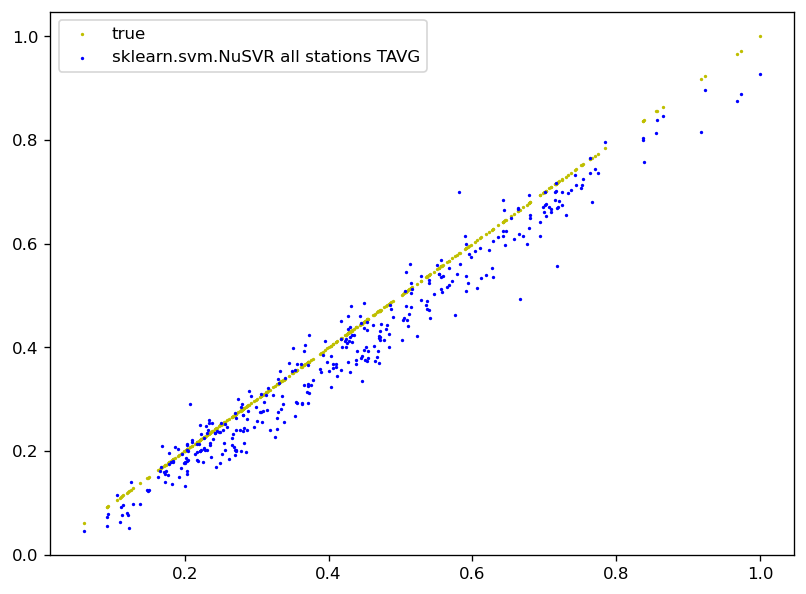

,Algorithm,Explained Variance,R2/COD,Max Error,Mean AE,Mean Squared Error,MAPE,Median AE
0,sklearn.svm.NuSVR all stations TAVG,0.968348,0.94576,0.172598,0.036761,0.002103,0.101619,0.031214


In [14]:
model_desc = 'sklearn.svm.NuSVR all stations TAVG'

from sklearn.svm import NuSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#regr = make_pipeline(StandardScaler(), NuSVR(C=3.0, nu=0.1)) #originally C=1.0, nu=1.0
regr = NuSVR(C=3.0, nu=0.1, verbose=False ) #originally C=1.0, nu=1.0

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

# show results
myplot(model_desc, y_test, y_pred)

# save results for report
report = add_to_report(report, model_desc, y_test, y_pred)
report.tail(3)

In [15]:
#Example from https://pypi.org/project/sklearn-genetic/

from __future__ import print_function
import numpy as np
from sklearn import datasets, linear_model

from genetic_selection import GeneticSelectionCV

X = X_train
y = y_train



## Set the max number of features to search for here: 

In [16]:
max_features = 15

In [17]:
# from https://pypi.org/project/sklearn-genetic/
# source code at https://github.com/manuel-calzolari/sklearn-genetic/blob/master/genetic_selection/gscv.py



estimator = NuSVR(C=3.0, nu=0.1, verbose=False )

#from sklearn import ensemble
# estimator = ensemble.GradientBoostingRegressor(n_estimators=500, max_depth=4, min_samples_split=7, learning_rate = 0.03)

selector = GeneticSelectionCV(estimator,
                              cv=5,
                              verbose=1,
                              #scoring="accuracy",
                              max_features=max_features, # was 5
                              n_population=300, # was 50
                              crossover_proba=0.5,
                              mutation_proba=0.3, # was 0.2 
                              n_generations=25,
                              crossover_independent_proba=0.5,
                              mutation_independent_proba=0.15, # was 0.05
                              tournament_size=3,
                              n_gen_no_change=12,
                              caching=True,
                              n_jobs=3) # this cpu has 4 cores, 8 threads 

selector = selector.fit(X, y)

print(predictors_df.columns[selector.support_])

Selecting features with genetic algorithm.
gen	nevals	avg                    	std                    	min                      	max                      
0  	300   	[0.69649224 7.94333333]	[0.18958667 4.13200382]	[-1.06193224  1.        ]	[ 0.84378379 15.        ]
1  	201   	[-3432.81647927    23.23333333]	[4748.58976555   19.56865407]	[-1.e+04  3.e+00]        	[ 0.85980292 65.        ]
2  	193   	[-3566.14925988    23.80666667]	[4790.537187    19.6401618]  	[-1.e+04  3.e+00]        	[ 0.85980292 71.        ]
3  	197   	[-3466.13431748    23.72333333]	[4759.47265924   18.83861607]	[-1.e+04  3.e+00]        	[ 0.86919455 73.        ]
4  	178   	[-3632.80825402    25.41333333]	[4809.99355054   19.66729491]	[-1.e+04  5.e+00]        	[ 0.87269886 76.        ]
5  	195   	[-3532.79565046    24.47333333]	[4780.44858491   20.15909941]	[-1.e+04  4.e+00]        	[ 0.8858557 85.       ]  
6  	211   	[-3966.15945337    26.23333333]	[4892.46832222   20.55785873]	[-1.e+04  3.e+00]        	[ 0.8858557

## Now that I've found the N best predictors, re-do the SVM model with only those:


Input split into 1171 training observations and 364 testing observations.


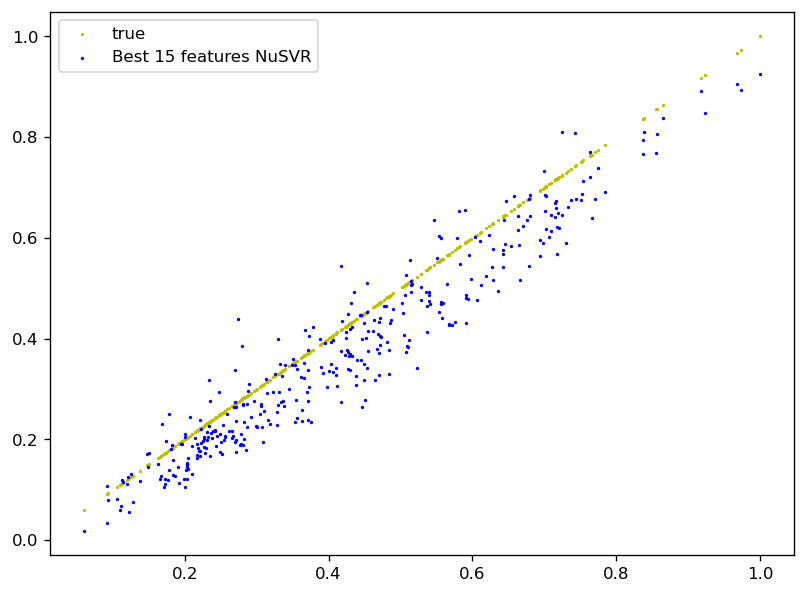

,Algorithm,Explained Variance,R2/COD,Max Error,Mean AE,Mean Squared Error,MAPE,Median AE
0,sklearn.svm.NuSVR all stations TAVG,0.968348,0.945760,0.172598,0.036761,0.002103,0.101619,0.031214
1,Best 15 features NuSVR,0.929386,0.873532,0.182141,0.058045,0.004904,0.157744,0.053216


In [18]:


new_predictors_df = predictors_df[predictors_df.columns[selector.support_]].copy()

new_predictor_names = new_predictors_df.columns.to_numpy()
new_predictors = new_predictors_df.to_numpy()

scaler = MinMaxScaler((0, 1))
X = scaler.fit_transform(new_predictors)
y = scaler.fit_transform(target.reshape(-1, 1)).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .237, shuffle=False)
print (f"Input split into {len(y_train)} training observations and {len(y_test)} testing observations.")

model_desc = 'Best '+ str(max_features) + ' features NuSVR'

regr = NuSVR(C=3.0, nu=0.1, verbose=False ) #originally C=1.0, nu=1.0

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

# show results
myplot(model_desc, y_test, y_pred)

# save results for report
report = add_to_report(report, model_desc, y_test, y_pred)
report

## Compare to highest scoring feature set from previous runs

Input split into 1171 training observations and 364 testing observations.


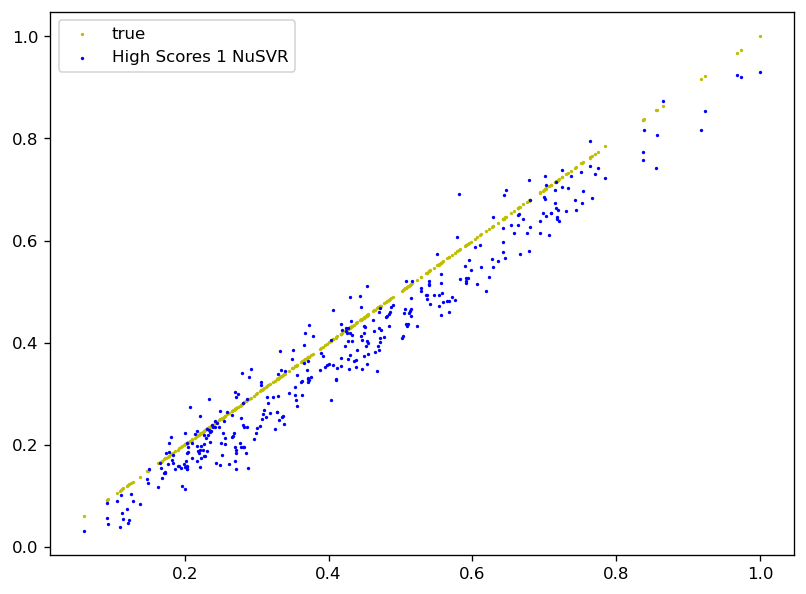

,Algorithm,Explained Variance,R2/COD,Max Error,Mean AE,Mean Squared Error,MAPE,Median AE
0,sklearn.svm.NuSVR all stations TAVG,0.968348,0.945760,0.172598,0.036761,0.002103,0.101619,0.031214
1,Best 15 features NuSVR,0.929386,0.873532,0.182141,0.058045,0.004904,0.157744,0.053216
2,High Scores 1 NuSVR,0.960540,0.925591,0.133902,0.045522,0.002885,0.129546,0.043410


In [19]:
new_predictors_df = target_df[[
    'is_Saturday', 
    'is_Sunday',
    'is_holiday', 
    "holiday_New Year's Day",
    'TAVG_KS_DODGE_CITY',
    'TAVG_LA_SHREVEPORT', 
    'TAVG_MO_SPRINGFIELD',
    'TAVG_NE_LINCOLN_MUNI_AP', 
    'TAVG_OK_LAWTON_MUNI_AP',
    'TAVG_WY_TORRINGTON_MUNI_AP',
    'TAVG_AR_FT_SMITH_RGNL_AP', 
    'TAVG_IA_SIOUX_CITY_GATEWAY_AP',
]].copy()

#  see if opmonth or opyear help or hurt:
#new_predictors_df['opmonth'] = (target_df.opday.dt.year - 2015) * 12 + target_df.opday.dt.month 
#new_predictors_df['opyear'] = (target_df.opday.dt.year - 2015)
#  verdict:  hurt

new_predictor_names = new_predictors_df.columns.to_numpy()
new_predictors = new_predictors_df.to_numpy()

scaler = MinMaxScaler((0, 1))
X = scaler.fit_transform(new_predictors)
y = scaler.fit_transform(target.reshape(-1, 1)).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .237, shuffle=False)
print (f"Input split into {len(y_train)} training observations and {len(y_test)} testing observations.")

model_desc = 'High Scores 1 NuSVR'

regr = NuSVR(C=3.0, nu=0.1, verbose=False ) #originally C=1.0, nu=1.0

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

# show results
myplot(model_desc, y_test, y_pred)

# save results for report
report = add_to_report(report, model_desc, y_test, y_pred)
report

## Next I'll use the stations and holidays identified here as relevent in more scikit-learn algorithms.